In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
path = '/content/gdrive/MyDrive/lastFM'

In [3]:
scrob = pd.read_csv(path + '/lastfm_user_scrobbles_10k200_through2021.csv')
artist = pd.read_csv(path + '/artists.tsv', sep='\t')

In [4]:
scrob.columns

Index(['user_id', 'artist_id', 'scrobbles'], dtype='object')

In [5]:
scrob.isna().sum()

,0
user_id,0
artist_id,0
scrobbles,0


In [6]:
scrob.dropna().drop_duplicates()

,user_id,artist_id,scrobbles
0,0,0,1918
1,0,1,1735
2,0,2,1660
3,0,3,1282
4,0,4,743
...,...,...,...
1921293,9999,1378,8
1921294,9999,9940,7
1921295,9999,73678,7
1921296,9999,4964,7


In [7]:
scrob = scrob.merge(artist, on='artist_id')
scrob.columns

Index(['user_id', 'artist_id', 'scrobbles', 'artist_name'], dtype='object')

In [8]:
scrob.dropna().drop_duplicates()

,user_id,artist_id,scrobbles,artist_name
0,0,0,1918,Jacob Collier
1,0,1,1735,Adrianne Lenker
2,0,2,1660,Pink Floyd
3,0,3,1282,Johann Sebastian Bach
4,0,4,743,Alfa Mist
...,...,...,...,...
1921274,9999,1378,8,Whitesnake
1921275,9999,9940,7,Anvil
1921276,9999,73678,7,Danny Davis & The Nashville Brass
1921277,9999,4964,7,Deeb


In [9]:
scrob.dropna(subset=['artist_name'])

,user_id,artist_id,scrobbles,artist_name
0,0,0,1918,Jacob Collier
1,0,1,1735,Adrianne Lenker
2,0,2,1660,Pink Floyd
3,0,3,1282,Johann Sebastian Bach
4,0,4,743,Alfa Mist
...,...,...,...,...
1921274,9999,1378,8,Whitesnake
1921275,9999,9940,7,Anvil
1921276,9999,73678,7,Danny Davis & The Nashville Brass
1921277,9999,4964,7,Deeb


In [10]:
scrob.isna().sum()

,0
user_id,0
artist_id,0
scrobbles,0
artist_name,6


In [11]:
class DotProduct(Module):
    def __init__(self, n_users, n_artist, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.artist_factors = Embedding(n_artist, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        artist = self.artist_factors(x[:,1])
        return (users * artist).sum(dim=1)

In [12]:
class DotProduct(Module):
    def __init__(self, n_users, n_artist, n_factors, y_range=(-2,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.artist_factors = Embedding(n_artist, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        artist = self.artist_factors(x[:,1])
        return sigmoid_range((users * artist).sum(dim=1), *self.y_range)

In [13]:
def create_artist_similarity_df(model, dls, scrob_df):
    """Creates a DataFrame of artist similarities based on their embeddings."""

    artist_embeddings = model.artist_factors.weight.cpu().detach().numpy()

    artist_similarity_matrix = cosine_similarity(artist_embeddings)

    artist_names = scrob_df['artist_name'].unique()

    artist_similarity_df = pd.DataFrame(artist_similarity_matrix, index=artist_names, columns=artist_names)

    return artist_similarity_df

In [14]:
def recommend_artists_by_artists(artist_names, top_k=10):
    """Recommends artists based on the combined similarity of multiple input artists."""

    similarity_scores = artist_similarity_df[artist_names].mean(axis=1)

    similar_artists = similarity_scores.drop(artist_names).sort_values(ascending=False)[:top_k].index.tolist()

    print(f"Artists similar to {', '.join(artist_names)}:")
    for artist in similar_artists:
        print(artist)

In [15]:
scrob['scrobbles_log'] = np.log1p(scrob['scrobbles'])
scaler = StandardScaler()
scrob['scrobbles_standardized'] = scaler.fit_transform(scrob[['scrobbles_log']])

In [16]:
highest_value = scrob['scrobbles_standardized'].max()
lowest_value = scrob['scrobbles_standardized'].min()
print(lowest_value)
print(highest_value)

-1.8983347004511568
5.286530271747699


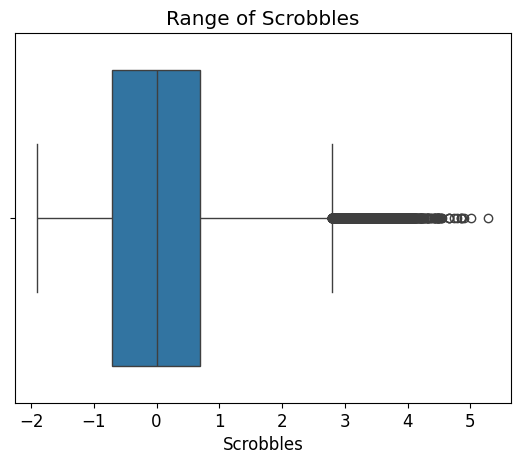

In [17]:
sns.boxplot(x=scrob['scrobbles_standardized'])
plt.xlabel('Scrobbles')
plt.title('Range of Scrobbles')
plt.show()

In [18]:
scrob

,user_id,artist_id,scrobbles,artist_name,scrobbles_log,scrobbles_standardized
0,0,0,1918,Jacob Collier,7.559559,2.177906
1,0,1,1735,Adrianne Lenker,7.459339,2.118410
2,0,2,1660,Pink Floyd,7.415175,2.092192
3,0,3,1282,Johann Sebastian Bach,7.156956,1.938901
4,0,4,743,Alfa Mist,6.612041,1.615412
...,...,...,...,...,...,...
1921274,9999,1378,8,Whitesnake,2.197225,-1.005440
1921275,9999,9940,7,Anvil,2.079442,-1.075362
1921276,9999,73678,7,Danny Davis & The Nashville Brass,2.079442,-1.075362
1921277,9999,4964,7,Deeb,2.079442,-1.075362


In [19]:
dls = CollabDataLoaders.from_df(scrob, user_name='user_id', item_name='artist_name', rating_name='scrobbles_standardized', bs=64)
dls.show_batch()

,user_id,artist_name,scrobbles_standardized
0,7929,The Weeknd,1.400472
1,2668,Minor Threat,0.212295
2,4677,Brooke Candy,-0.105262
3,3282,Van Morrison,0.079826
4,5761,Julieta Venegas,-0.182468
5,4944,Harry Styles,1.535229
6,1363,Mark Ronson,-0.036951
7,7134,Harmless,0.268876
8,303,Frank Sinatra,-0.290703
9,3534,Adi Nowak,-0.398938


In [20]:
n_users  = len(dls.classes['user_id'])
n_artist = len(dls.classes['artist_name'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
artist_factors = torch.randn(n_artist, n_factors)

In [21]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [22]:
model = DotProduct(n_users, n_artist, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [23]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,time
0,2.853954,2.875589,02:12
1,1.003977,1.052045,02:12
2,0.640275,0.759987,02:13
3,0.485375,0.668237,02:12
4,0.405443,0.626600,02:12
5,0.384757,0.605115,02:13
6,0.345668,0.593111,02:12
7,0.325681,0.581772,02:12
8,0.285641,0.571960,02:13
9,0.272010,0.565355,02:12


In [24]:
learn.export('modelOne.pkl')

In [25]:
model = DotProduct(n_users, n_artist, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,1.983546,2.001204,02:12
1,0.776066,0.864859,02:13
2,0.555639,0.696587,02:13
3,0.450387,0.640371,02:13
4,0.375918,0.611635,02:13
5,0.334561,0.591541,02:12
6,0.316464,0.577178,02:13
7,0.303514,0.567345,02:13
8,0.295295,0.562233,02:13
9,0.309293,0.561163,02:13


In [26]:
artist_similarity_df = create_artist_similarity_df(model, dls, scrob)

In [27]:
input_artists = ["The Weeknd", "Pink Floyd", "Frank Sinatra"]
recommend_artists_by_artists(input_artists, top_k=5)

Artists similar to The Weeknd, Pink Floyd, Frank Sinatra:
Scandinavian Strings
Hagazo
Nicki Bluhm
The Ascent Of Everest
Alam


In [28]:
artist_similarity_df

Jacob Collier  Adrianne Lenker  Pink Floyd  \
Jacob Collier               1.000000         0.867472    0.860745   
Adrianne Lenker             0.867472         1.000000    0.802904   
Pink Floyd                  0.860745         0.802904    1.000000   
Johann Sebastian Bach       0.859481         0.857945    0.662292   
Alfa Mist                   0.898192         0.898535    0.747171   
...                              ...              ...         ...   
Highlonesome                0.823321         0.839682    0.691308   
Runaway Planet              0.940093         0.815364    0.759327   
Pete Komaroski              0.911805         0.916879    0.769643   
The Weary Boys              0.852678         0.847178    0.645031   
Newrappy                    0.968915         0.844090    0.894881   

                       Johann Sebastian Bach  Alfa Mist  Funky DL  \
Jacob Collier                       0.859481   0.898192  0.850964   
Adrianne Lenker                     0.857945   0.898535  0.832373   
Pink Floyd                          0.662292   0.747171  0.673275   
Johann Sebastian Bach               1.000000   0.967189  0.954772   
Alfa Mist                           0.967189   1.000000  0.964614   
...                                      ...        ...       ...   
Highlonesome                        0.957740   0.960267  0.918803   
Runaway Planet                      0.885934   0.925750  0.903216   
Pete Komaroski                      0.888640   0.954580  0.905178   
The Weary Boys                      0.994490   0.960452  0.947845   
Newrappy                            0.762710   0.823878  0.787087   

                       Esperanza Spalding  The Microphones  The Beatles  \
Jacob Collier                   -0.240144         0.958615     0.975466   
Adrianne Lenker                 -0.168652         0.882843     0.842892   
Pink Floyd                      -0.310908         0.844558     0.889367   
Johann Sebastian Bach           -0.204952         0.794332     0.771107   
Alfa Mist                       -0.225143         0.855997     0.828318   
...                                   ...              ...          ...   
Highlonesome                    -0.208092         0.751224     0.732193   
Runaway Planet                  -0.213242         0.901624     0.868147   
Pete Komaroski                  -0.227091         0.908699     0.873076   
The Weary Boys                  -0.194916         0.780308     0.760972   
Newrappy                        -0.266923         0.943308     0.995167   

                       Richard Wagner  John Coltrane   Nujabes  Thundercat  \
Jacob Collier                0.968619       0.936453  0.820401    0.905751   
Adrianne Lenker              0.857592       0.882915  0.841702    0.856482   
Pink Floyd                   0.888342       0.830776  0.695815    0.734680   
Johann Sebastian Bach        0.779116       0.833927  0.953618    0.947450   
Alfa Mist                    0.840925       0.868313  0.956640    0.921957   
...                               ...            ...       ...         ...   
Highlonesome                 0.740237       0.797538  0.995939    0.891437   
Runaway Planet               0.860970       0.872909  0.853436    0.877745   
Pete Komaroski               0.888996       0.883267  0.842764    0.878669   
The Weary Boys               0.769817       0.822349  0.952499    0.940292   
Newrappy                     0.994232       0.939921  0.719939    0.854891   

                         Noname      Moow  Hiatus Kaiyote  Mac Miller  \
Jacob Collier          0.864395 -0.102756        0.694227    0.934727   
Adrianne Lenker        0.930929 -0.178414        0.790658    0.865552   
Pink Floyd             0.697938  0.002124        0.646327    0.852820   
Johann Sebastian Bach  0.960801 -0.190005        0.831974    0.832770   
Alfa Mist              0.956184 -0.150001        0.838307    0.852831   
...                         ...       ...             ...         ...   
Highlonesome    

In [29]:
learn.export('modelTwo.pkl')